# Checking organismQuantity field in OBIS

This notebook uses the entire OBIS database, dumped as a parquet file, to sort a filter out occurrences where the data provider gave an `organismQuantity` and `organismQuantityType`. 

In [1]:
import humanize
import os
import pandas as pd

# file downloaded from https://obis.org/data/access/ on 2022-07-10
file = '../obis_20220710.parquet'
#file = 's3://gbif-open-data-eu-central-1/occurrence/2022-07-01/occurrence.parquet'

 
file_size = humanize.naturalsize(os.path.getsize(file))
print('File Size is:', file_size)

File Size is: 13.3 GB


This file is large, so we need to only load in the data we need. So we will pre-select the columns of interest. Then we can read it into memory.

In [16]:
columns = ['organismQuantity', 'organismQuantityType','decimalLatitude','decimalLongitude']

df = pd.read_parquet(file, engine="fastparquet", columns=columns)

In [13]:
#df = pd.read_parquet(file, engine="fastparquet")

df.

Index(['organismQuantity', 'organismQuantityType', 'decimalLatitude',
       'decimalLongitude', 'taxonRank'],
      dtype='object')

Let's check the size of the monster:

In [23]:
df['taxonRank'].unique()

array(['Species', 'Genus', None, 'Variety', 'Family', 'Superfamily',
       'Subgenus', 'Order', 'Subspecies', 'Infraorder', 'Class',
       'Subfamily', 'Phylum (Division)', 'Subclass', 'Phylum', 'Suborder',
       'Forma', 'Superclass', 'Subphylum (Subdivision)', 'Parvphylum',
       'Subkingdom', 'Subterclass', 'Subphylum', 'Subsection',
       'Subvariety', 'Infrakingdom', 'Infraclass', 'Infraphylum', 'Tribe',
       'Superorder', 'Kingdom', 'Parvorder', 'Superphylum'], dtype=object)

In [18]:
nbytes = df.memory_usage(index=True, deep=True)

subset_size = humanize.naturalsize(nbytes.sum())

print('Subset size is:',subset_size)

Subset size is: 18.2 GB


Okay, let's filter out where `organismQuantityType` or `organismQuantity` don't have values. We need both to exist!

In [19]:
df_filtered = df[(df['organismQuantityType'].notna() | df['organismQuantity'].notna())]

df_filtered.shape

(27292364, 6)

Let's make a map of the points we have for some context.

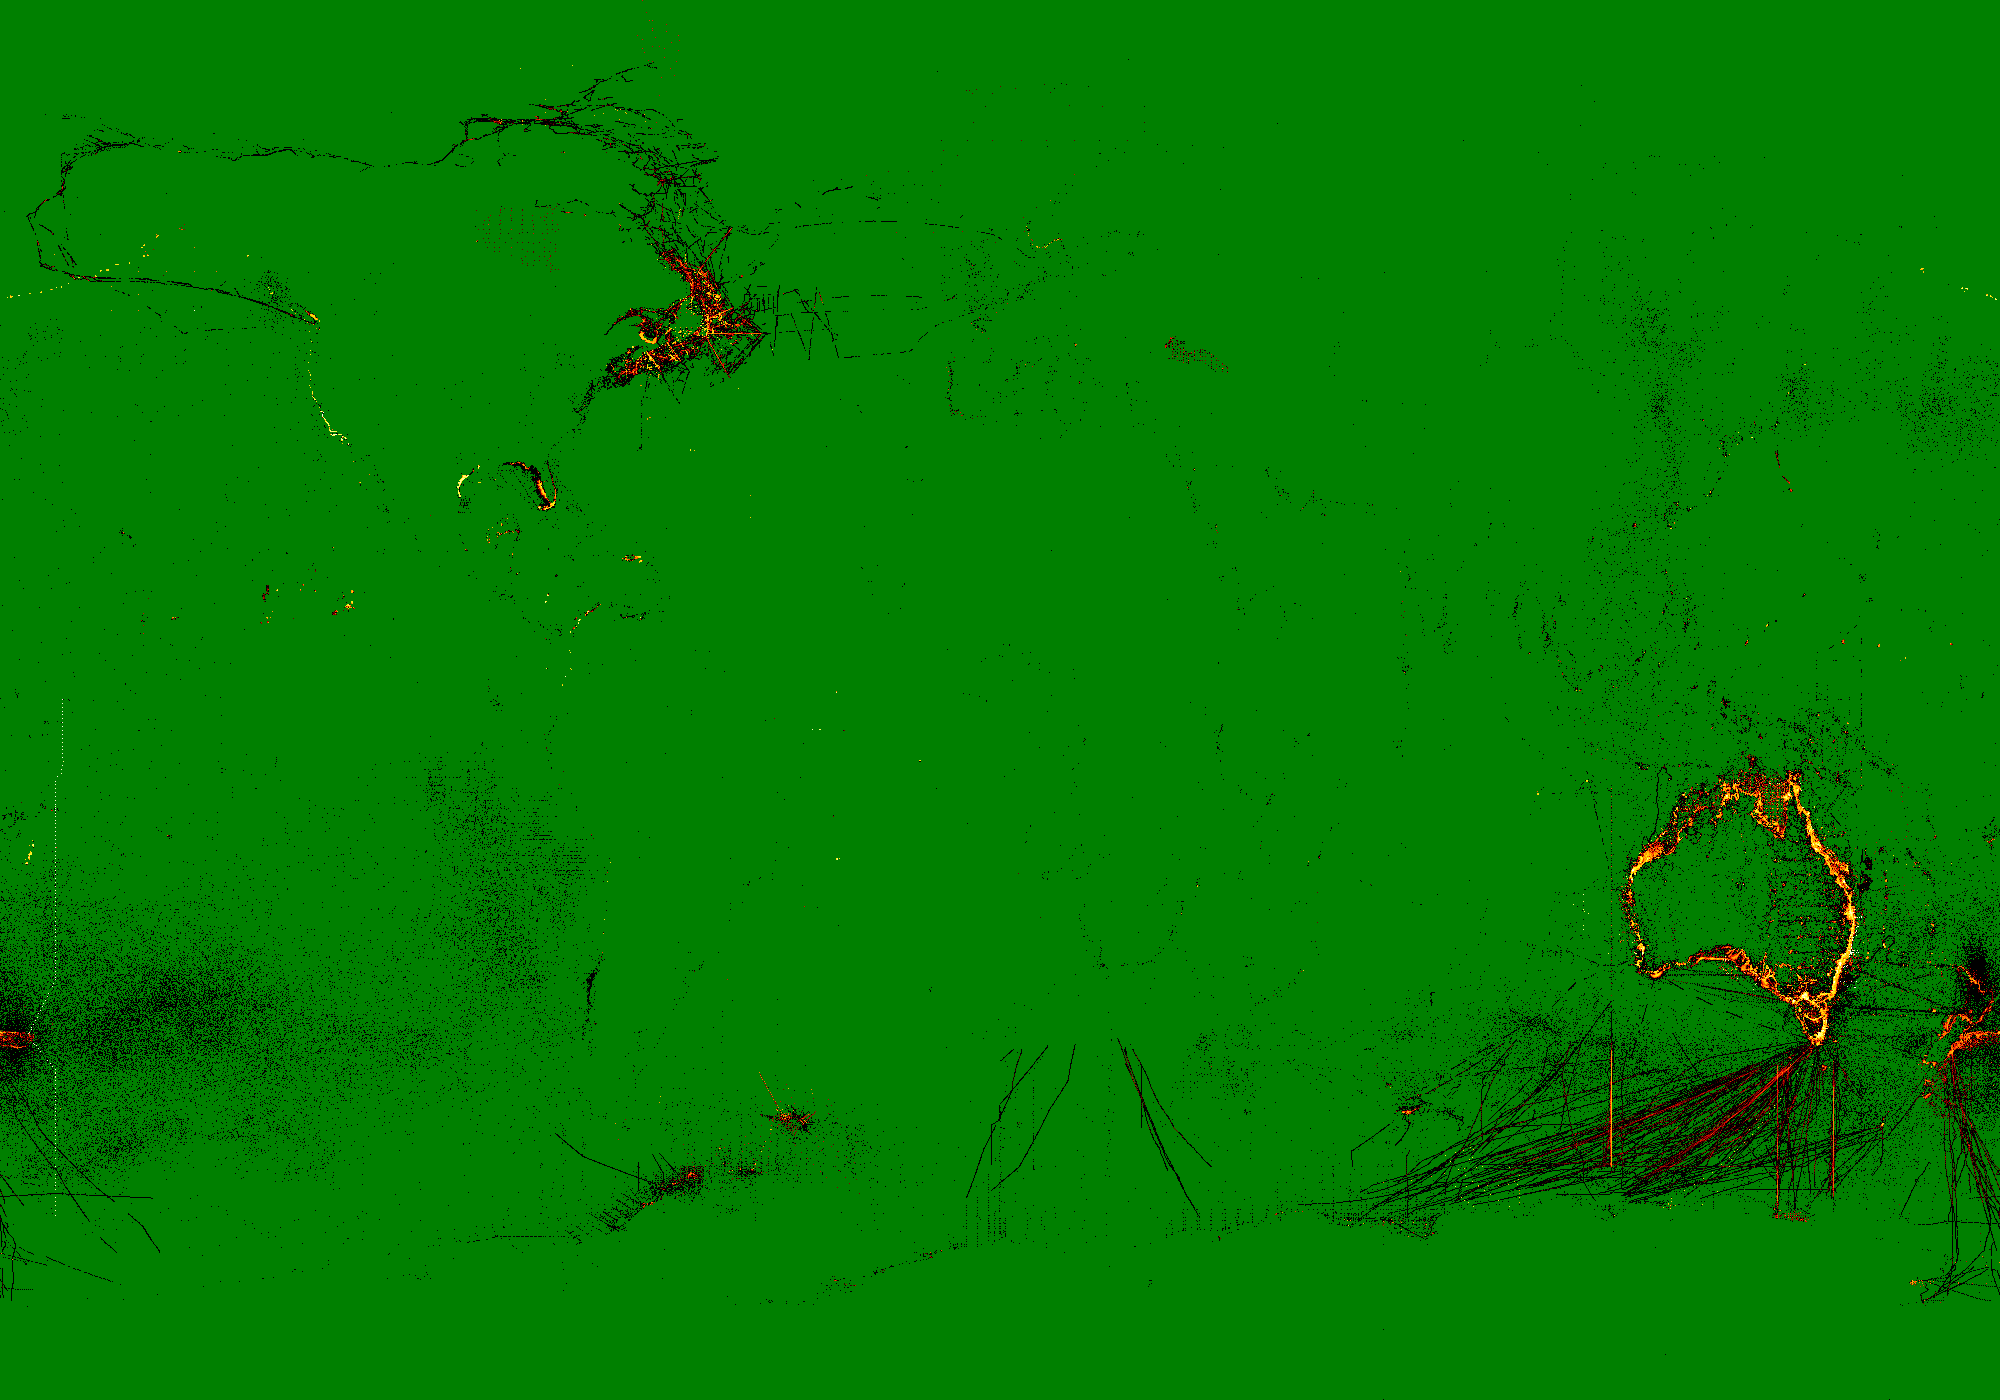

In [39]:
import datashader as ds
import colorcet
#df  = pd.read_csv('census.csv')
cvs = ds.Canvas(plot_width=2000, plot_height=1400)
agg = cvs.points(df_filtered, 'decimalLongitude', 'decimalLatitude')
img = ds.tf.set_background(
            ds.tf.shade(agg, 
                cmap=colorcet.fire, 
                how='eq_hist', 
                rescale_discrete_levels=True,
                ), 
            "green")

img

In [33]:
help(ds.tf.shade)

Help on function shade in module datashader.transfer_functions:

shade(agg, cmap=['lightblue', 'darkblue'], color_key=['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999', '#66c2a5', '#fc8d62', '#8da0cb', '#a6d854', '#ffd92f', '#e5c494', '#ffffb3', '#fb8072', '#fdb462', '#fccde5', '#d9d9d9', '#ccebc5', '#ffed6f'], how='eq_hist', alpha=255, min_alpha=40, span=None, name=None, color_baseline=None, rescale_discrete_levels=False)
    Convert a DataArray to an image by choosing an RGBA pixel color for each value.
    
    Requires a DataArray with a single data dimension, here called the
    "value", indexed using either 2D or 3D coordinates.
    
    For a DataArray with 2D coordinates, the RGB channels are computed
    from the values by interpolated lookup into the given colormap
    ``cmap``.  The A channel is then set to the given fixed ``alpha``
    value for all non-zero values, and to zero for all zero values.
    A dictionary ``color_ke

Let's see what the number of records for each unique `organismQuantityType` looks like:

In [9]:
pd.set_option('display.max_rows', 160)
df_group = df.groupby(by='organismQuantityType').count()

df_group.drop(columns=['decimalLatitude','decimalLongitude'], inplace=True)

df_group.rename(columns={'organismQuantity':'count'}, inplace=True)

df_group.sort_values(by='count', ascending=False)

,count
organismQuantityType,
DNA sequence reads,17099687
individuals,4258861
detections per day,1510107
individual,533275
Relative Abundance,374608
Individuals,211118
number of individuals per 120 m3,153944
Cells per litre,132071
biomass in kilograms (kg),115079


Numbers are nice, but I'm a visual person. Show me a histogram of the number of records for each `organismQuantity` so I can visually see which ones occur the most.

<AxesSubplot:xlabel='organismQuantityType', ylabel='count'>

C:\Users\Mathew.Biddle\programs\Anaconda3\envs\globe\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 150 (\x96) missing from current font.
  func(*args, **kwargs)
C:\Users\Mathew.Biddle\programs\Anaconda3\envs\globe\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


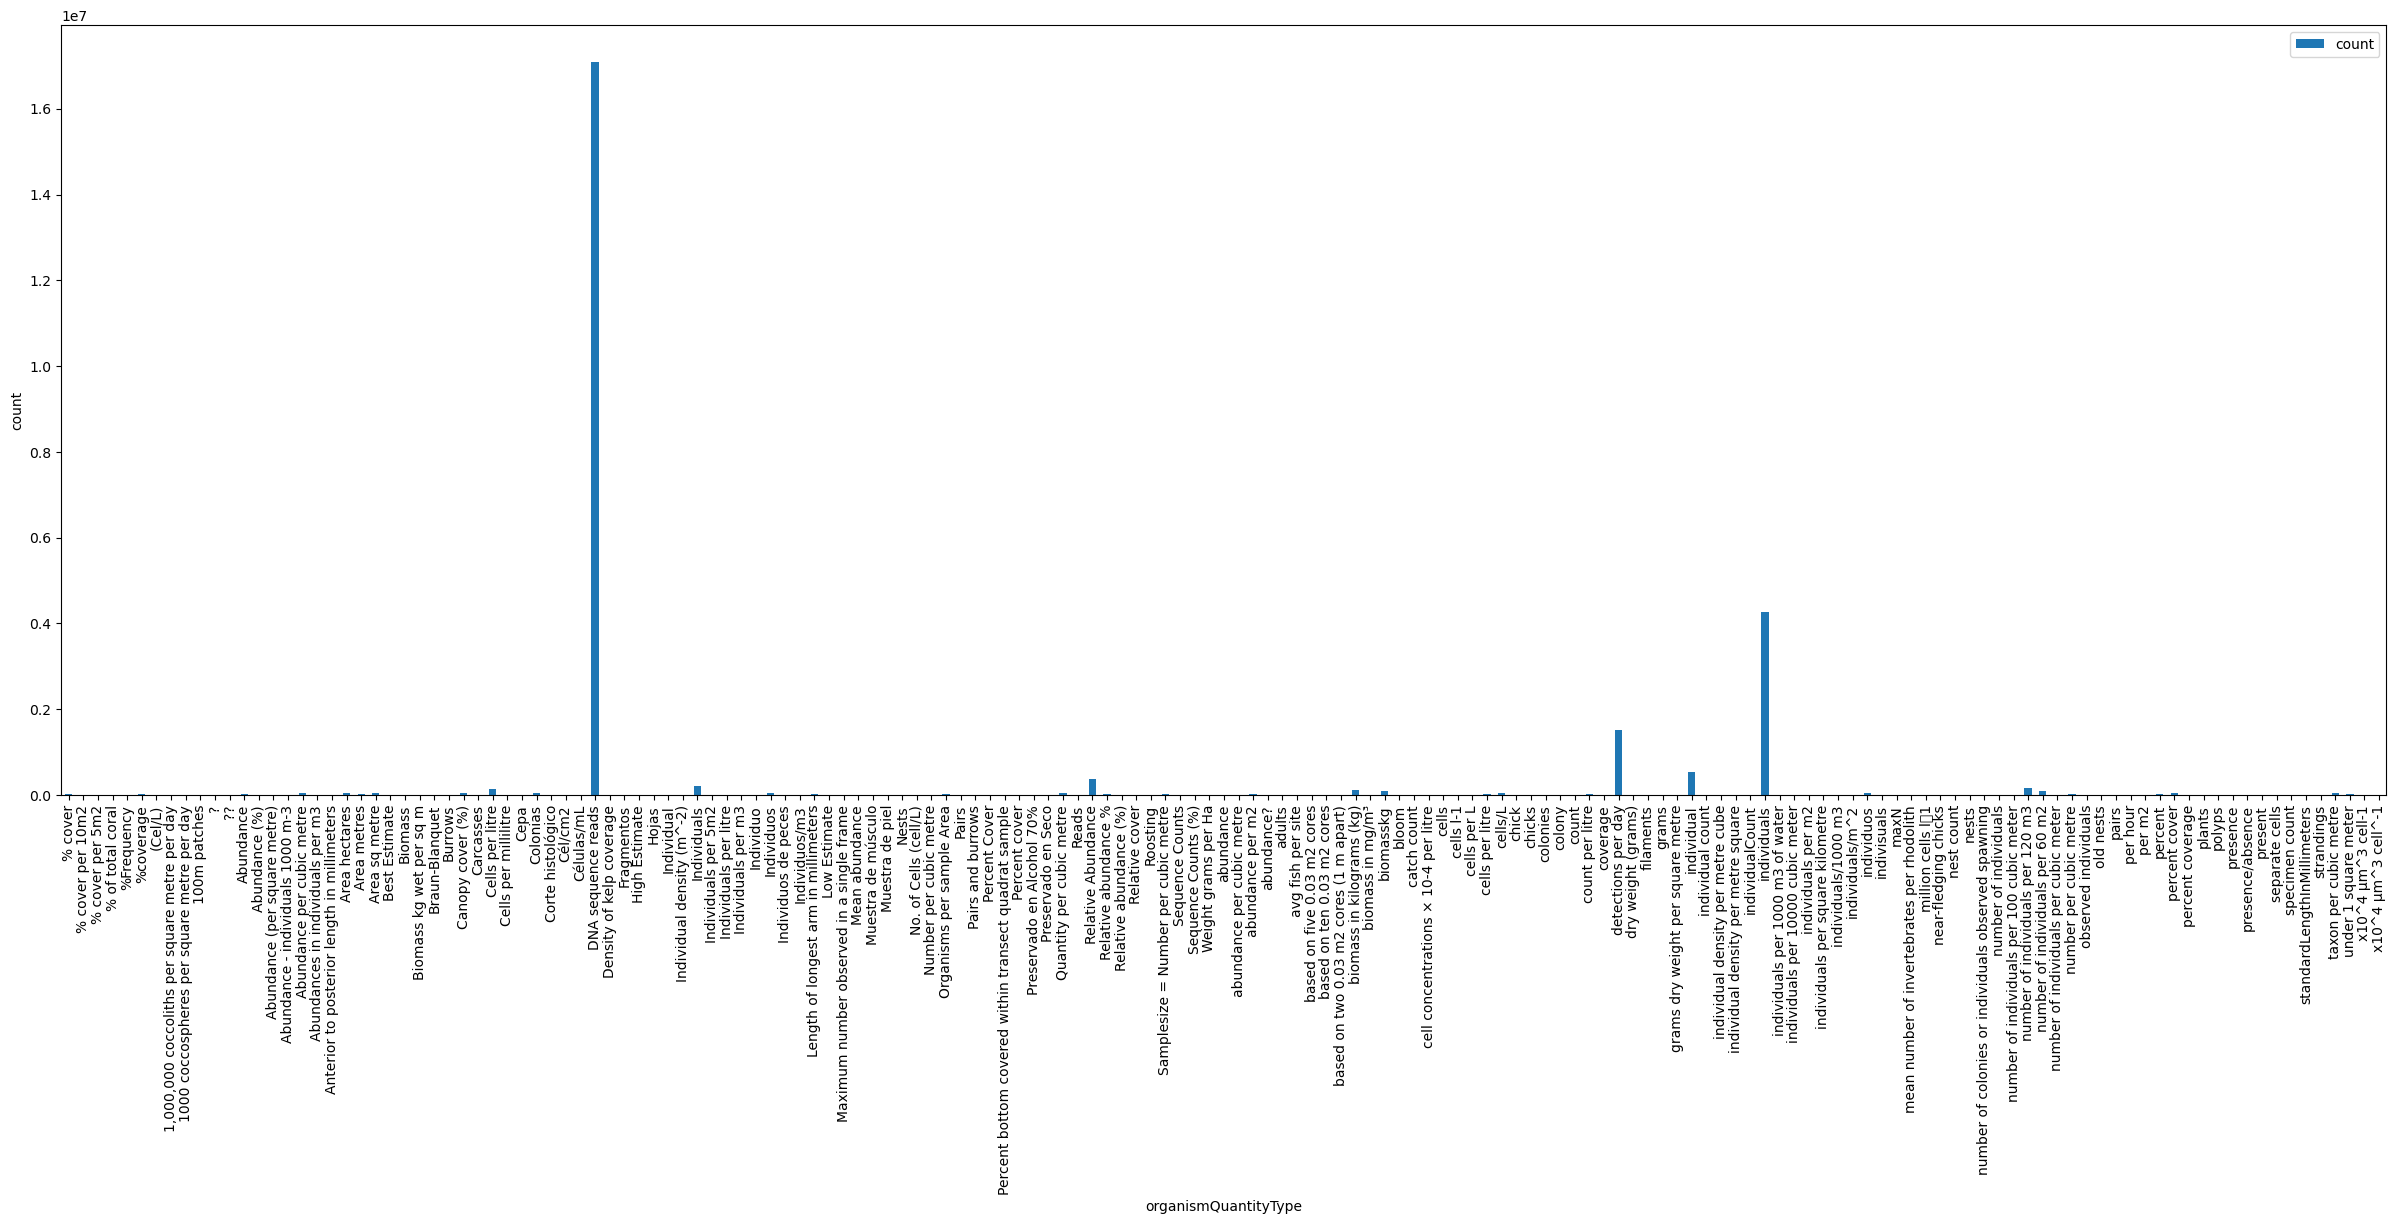

In [10]:
df_group.reset_index(inplace=True)

df_group.plot.bar(x='organismQuantityType',y='count',
                                figsize=(30,10),
                                ylabel='count',
                               )

That's a lot of different `organismQuantityTypes`. How about I pick the top 20 cited ones?

In [13]:
top_20 = df_group.sort_values(by='count', ascending=False).head(20)['organismQuantityType'].tail(19)


df_top_20 = df_group.loc[df_group['organismQuantityType'].isin(top_20)]

df_top_20.sort_values(by='count', ascending=False)

,organismQuantityType,count
116,individuals,4258861
106,detections per day,1510107
111,individual,533275
70,Relative Abundance,374608
43,Individuals,211118
134,number of individuals per 120 m3,153944
29,Cells per litre,132071
88,biomass in kilograms (kg),115079
135,number of individuals per 60 m2,83765
90,biomasskg,80982


That's a little more manageable. Let's make a histogram of that distribution:

<AxesSubplot:xlabel='organismQuantityType', ylabel='count'>

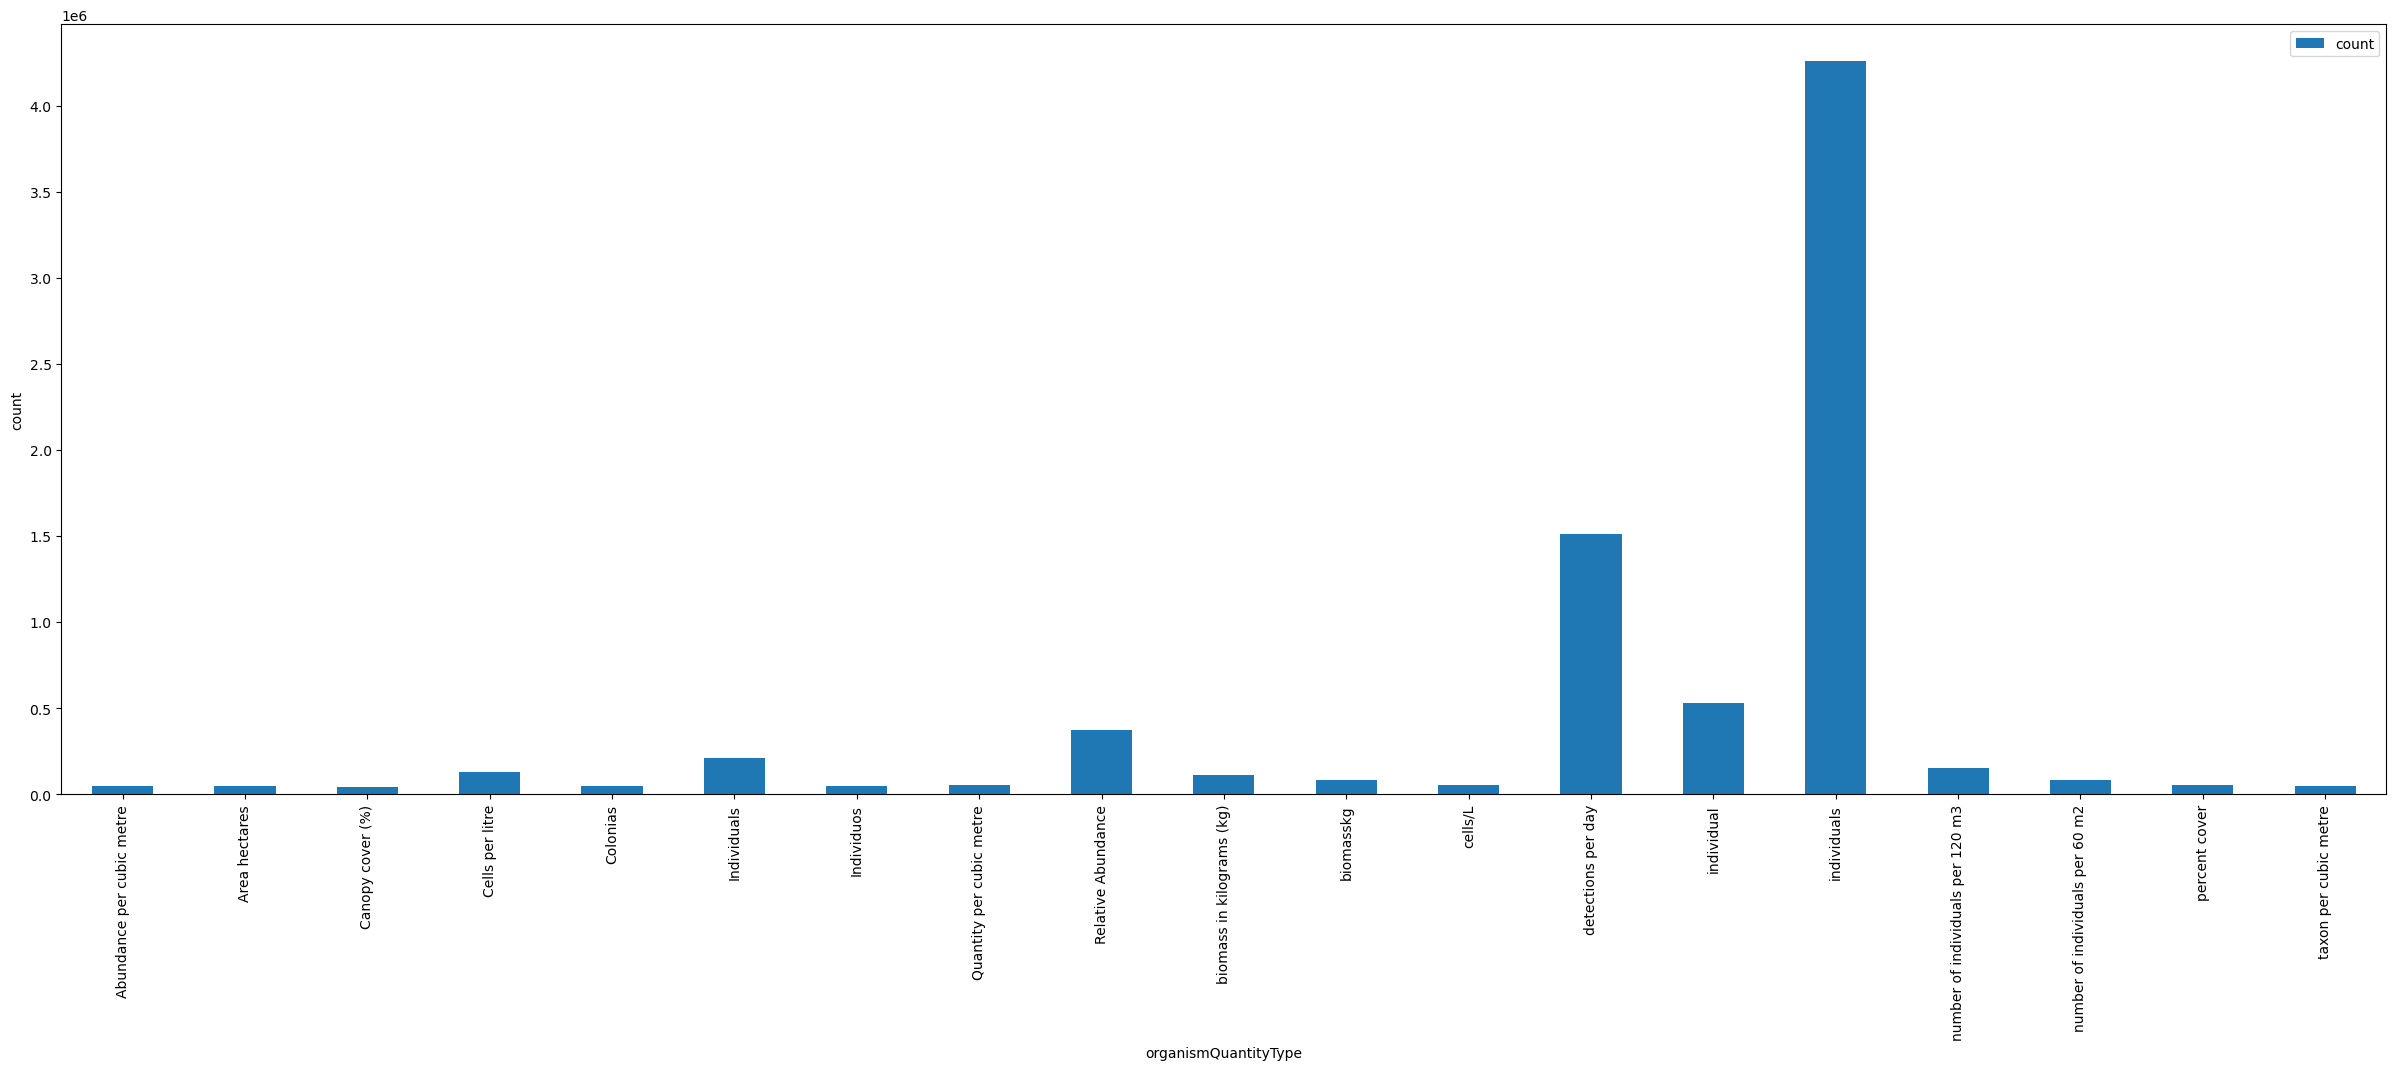

In [14]:
df_top_20.plot.bar(x='organismQuantityType',y='count',
                                figsize=(30,10),
                                ylabel='count',
                               )

Looks like `DNA sequence reads` accounts for most of the `organismQuantityTypes`.